# IMPORT MODULES & FUNCTIONS

In [1]:
#IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
import calendar
import seaborn as sns; sns.set()
import itertools
#import datetime
from time import gmtime, strftime
from matplotlib import cm
from IPython.display import display
#%matplotlib qt
#%matplotlib inline

#SET GLOBAL PARAMETERS
# ================== Global parameters for fonts & sizes =================
FONT_SIZE = 20
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': FONT_SIZE, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

from solarcurtailment.energy_calculation import *
from solarcurtailment.clear_sky_day import *
from solarcurtailment.tripping_curt import *
from solarcurtailment.vvar_curt import *
from solarcurtailment.vwatt_curt import *
from solarcurtailment.polyfit import *
from solarcurtailment.file_processing import *
from solarcurtailment.data_visualization import *

#class instantiation
file_processing = FileProcessing()
clear_sky_day = ClearSkyDay()
data_visualization = DataVisualization()
energy_calculation = EnergyCalculation()
tripping_curt = TrippingCurt()
polyfit_f = Polyfit()
vvar_curt = VVarCurt()
vwatt_curt = VWattCurt()

#from FileProcessing 
def input_monthly_files(file_path, data_date_idx):
    """Open time-series D-PV data and ghi data of a certain month. Only compatible for SoLA data format.

    Args:
        file_path (str): The file location of the data
        data_date_idx (str): The month of the files in format 'YYYYMM' eg '201907'

    Returns:
        data (df): the opened & cleaned time-series D-PV data
        ghi (df): the opened & cleaned ghi data
        data_ori (df): the opened & unmodified time-series D-PV data
        ghi_ori (df): the opened & unmodified ghi data
    """
    
    data_path = file_path + r"/processed_unsw_" + data_date_idx + '_data_raw.csv'
    data_ori = pd.read_csv(data_path)
    data = data_ori.set_index('utc_tstamp')

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"/sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 
    ghi_ori = ghi.copy()

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    
    return data, ghi, data_ori, ghi_ori

C:\Users\samha\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# CHECK ALL DAYS
Find list of all dates which data are available

In [2]:
def create_date_list(year, month, num_of_days):
    """Create a list of date as str for certain month and year.

    Args:
        year (str): year
        month (str): month
        num_of_days (int): number of days for a certain month and year. 

    Returns:
        date_list (list): list of date as str
    """
    
    date_list = []
    
    for i in range(1, 10):
        date_list.append(year + '-' + month + '-0'  + str(i))
    for i in range(10, num_of_days + 1):
        date_list.append(year + '-' + month + '-'  + str(i))
    
    return date_list

In [3]:
datelist_201909 = create_date_list('2019', '09', 30)
datelist_201910 = create_date_list('2019', '10', 31)
datelist_201911 = create_date_list('2019', '11', 30)
datelist_201912 = create_date_list('2019', '12', 31)
datelist_202001 = create_date_list('2020', '01', 31)
datelist_202002 = create_date_list('2020', '02', 29)
datelist_202003 = create_date_list('2020', '03', 31)
datelist_202004 = create_date_list('2020', '04', 30)


date_list = datelist_201909 + datelist_201910 + datelist_201911 + datelist_201912 + datelist_202001 + datelist_202002 + datelist_202003 + datelist_202004

# CLEAR SKY DAYS LIST

In [4]:
csd_201909 = ['2019-09-12', '2019-09-17', '2019-09-18', '2019-09-26', '2019-09-29', '2019-09-30']
csd_201910 = ['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-29']
csd_201911 = ['2019-11-18', '2019-11-27']
csd_201912 = ['2019-12-16', '2019-12-19', '2019-12-25', '2019-12-28']
csd_202001 = ['2020-01-01', '2020-01-02', '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-17', '2020-01-29', '2020-01-30']
csd_202002 = ['2020-02-04', '2020-02-05', '2020-02-06', '2020-02-10', '2020-02-11', '2020-02-13', '2020-02-22', '2020-02-23']
csd_202003 = ['2020-03-03', '2020-03-08', '2020-03-10', '2020-03-14', '2020-03-15', '2020-03-25', '2020-03-26']
csd_202004 = ['2020-04-08', '2020-04-09', '2020-04-13', '2020-04-24']

csd_list = csd_201909 + csd_201910 + csd_201911 + csd_201912 + csd_202001 + csd_202002 + csd_202003 + csd_202004

# INPUT ALL MONTHLY DATA & GENERAL FILES

In [5]:
#file_path = r"/Users/samhan/Downloads/data" #for running in Samhan's laptop
file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer

month_list = ['201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004']
data = {}
data_ori = {}
ghi = {}
ghi_ori = {}
for month in month_list:
    print('processing {} ...'.format(month))
    data[month], ghi[month], data_ori[month], ghi_ori[month] = input_monthly_files(file_path, month)
    data[month]['date'] = data[month].index.date
    
site_details, unique_cids= file_processing.input_general_files(file_path)

processing 201909 ...
processing 201910 ...
processing 201911 ...
processing 201912 ...
processing 202001 ...
processing 202002 ...
processing 202003 ...
processing 202004 ...


In [19]:
data_all = pd.DataFrame()
for month in month_list:
    data_all = pd.concat([data_all, data[month]])

In [43]:
data_all['yearmonth'] = data_all.index.strftime('%Y%m')

In [44]:
data_all

,c_id,energy,power,reactive_power,voltage,duration,date,month,yearmonth
Timestamp,,,,,,,,,
2019-09-26 00:29:55+09:30,479577339,-98,-1.633333,6090,247.3,60,2019-09-26,9,201909
2019-09-26 00:29:55+09:30,280027210,-234,-3.900000,1864,242.5,60,2019-09-26,9,201909
2019-09-26 00:29:55+09:30,1471916197,-150,-2.500000,6090,248.4,60,2019-09-26,9,201909
2019-09-26 00:29:55+09:30,1658280060,-42,-0.700000,5798,243.1,60,2019-09-26,9,201909
2019-09-26 00:29:55+09:30,1254003935,-25,-0.416667,190,249.0,60,2019-09-26,9,201909
...,...,...,...,...,...,...,...,...,...
2020-04-29 18:01:55+09:30,492423664,99,1.650000,6808,240.2,60,2020-04-29,4,202004
2020-04-29 18:01:55+09:30,883238613,-132,-2.200000,5671,240.9,60,2020-04-29,4,202004
2020-04-29 18:01:55+09:30,1803391106,-152,-2.533333,12048,244.7,60,2020-04-29,4,202004


In [45]:
# OPTION: PUT THE YEARMONTH FOR EVERY MONTH BEFORE CONCATTING

# LOOP THE MOST CURTAILED SITE FOR ALL DAYS

In [ ]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []

for c_id in [1317822057]: #for testing
    last_month_analyzed = 0
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in date_list: 
        print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
            
        if not month_analyzed == last_month_analyzed:
            month_filter = data_all['month'] == month_analyzed
            data_certain_month = data_all.loc[month_filter]
            last_month_analyzed = month_analyzed
        
        if not last_cid_analyzed == c_id:
            site_id_filter = data_all['c_id'] == c_id
            data_certain_site = data_all.loc[site_id_filter]
        
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
            print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
            data_analyzed['power'].plot()
            plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(date_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

Analyzing c_id 1317822057 date 2019-09-01 ...
Cannot analyze 1317822057 site on 2019-09-01 due to incomplete data.


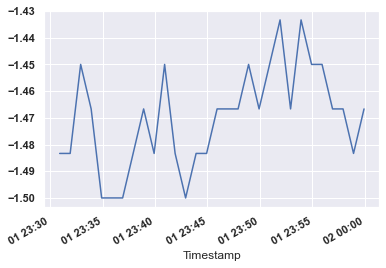

Analyzing c_id 1317822057 date 2019-09-02 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-03 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-04 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-05 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-06 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-07 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-08 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-09 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-10 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-11 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-14 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-15 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-16 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-17 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-18 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-19 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-20 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-21 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-22 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-23 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-24 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-27 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-09-28 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-29 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-09-30 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-01 ...
Cannot analyze 1317822057 site on 2019-10-01 due to incomplete data.


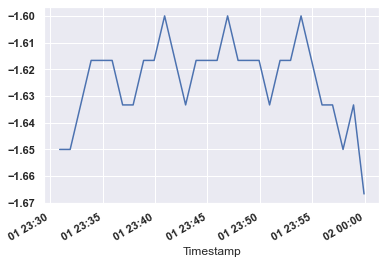

Analyzing c_id 1317822057 date 2019-10-02 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-03 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-04 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-05 ...
Analyzing c_id 1317822057 date 2019-10-06 ...
Analyzing c_id 1317822057 date 2019-10-07 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-08 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-09 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-10 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-11 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-14 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-15 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-16 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-17 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-18 ...
Analyzing c_id 1317822057 date 2019-10-19 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-20 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-21 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-10-22 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-10-23 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-10-24 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-27 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-28 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-10-29 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-30 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-10-31 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-01 ...
Cannot analyze 1317822057 site on 2019-11-01 due to incomplete data.


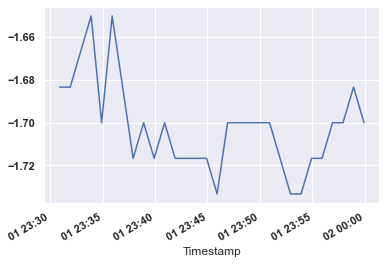

Analyzing c_id 1317822057 date 2019-11-02 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-03 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-04 ...
Analyzing c_id 1317822057 date 2019-11-05 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-06 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-07 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-08 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-09 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-10 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-11 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-14 ...
Analyzing c_id 1317822057 date 2019-11-15 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-16 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-17 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-18 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-19 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-20 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-21 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-22 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-23 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-24 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2019-11-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-27 ...
Analyzing c_id 1317822057 date 2019-11-28 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-29 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-11-30 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-01 ...
Cannot analyze 1317822057 site on 2019-12-01 due to incomplete data.


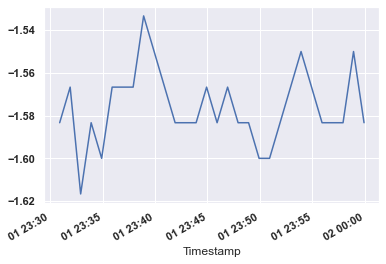

Analyzing c_id 1317822057 date 2019-12-02 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-03 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-04 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-05 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-06 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-07 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-08 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-09 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-10 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-11 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-14 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-15 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-16 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-17 ...
Analyzing c_id 1317822057 date 2019-12-18 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-19 ...
Analyzing c_id 1317822057 date 2019-12-20 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-21 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-22 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-23 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-24 ...
Analyzing c_id 1317822057 date 2019-12-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-27 ...
Analyzing c_id 1317822057 date 2019-12-28 ...
Analyzing c_id 1317822057 date 2019-12-29 ...
Analyzing c_id 1317822057 date 2019-12-30 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2019-12-31 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-01 ...
Cannot analyze 1317822057 site on 2020-01-01 due to incomplete data.


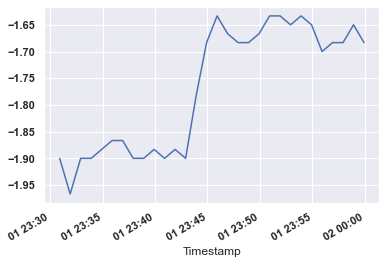

Analyzing c_id 1317822057 date 2020-01-02 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-03 ...
Analyzing c_id 1317822057 date 2020-01-04 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-05 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-06 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-07 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-08 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-09 ...
Analyzing c_id 1317822057 date 2020-01-10 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-11 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-14 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-15 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-16 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-17 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-18 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-19 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-20 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-21 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-22 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2020-01-23 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-24 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-27 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-28 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-01-29 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2020-01-30 ...
Analyzing c_id 1317822057 date 2020-01-31 ...
Analyzing c_id 1317822057 date 2020-02-01 ...
Cannot analyze 1317822057 site on 2020-02-01 due to incomplete data.


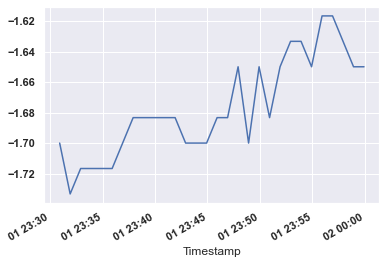

Analyzing c_id 1317822057 date 2020-02-02 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-03 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-04 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-05 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-06 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-07 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-08 ...
Analyzing c_id 1317822057 date 2020-02-09 ...
Analyzing c_id 1317822057 date 2020-02-10 ...
Analyzing c_id 1317822057 date 2020-02-11 ...
Analyzing c_id 1317822057 date 2020-02-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-14 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-15 ...
Analyzing c_id 1317822057 date 2020-02-16 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-17 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-18 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-19 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-20 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-21 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-22 ...
Analyzing c_id 1317822057 date 2020-02-23 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-24 ...
Analyzing c_id 1317822057 date 2020-02-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-27 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-02-28 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2020-02-29 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-01 ...
Cannot analyze 1317822057 site on 2020-03-01 due to incomplete data.


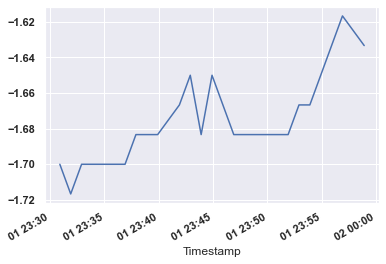

Analyzing c_id 1317822057 date 2020-03-02 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-03 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-04 ...
Analyzing c_id 1317822057 date 2020-03-05 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-06 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-07 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-08 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-09 ...
Analyzing c_id 1317822057 date 2020-03-10 ...
Analyzing c_id 1317822057 date 2020-03-11 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-14 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-15 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-16 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-17 ...
Analyzing c_id 1317822057 date 2020-03-18 ...
Analyzing c_id 1317822057 date 2020-03-19 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-20 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2020-03-21 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-22 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-23 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-24 ...
Analyzing c_id 1317822057 date 2020-03-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-27 ...
Analyzing c_id 1317822057 date 2020-03-28 ...
Analyzing c_id 1317822057 date 2020-03-29 ...
Analyzing c_id 1317822057 date 2020-03-30 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-03-31 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-01 ...
Cannot analyze 1317822057 site on 2020-04-01 due to incomplete data.


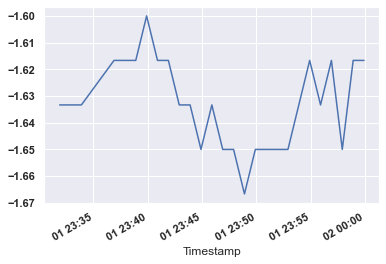

Analyzing c_id 1317822057 date 2020-04-02 ...
Analyzing c_id 1317822057 date 2020-04-03 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-04 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-05 ...
Analyzing c_id 1317822057 date 2020-04-06 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-07 ...
Analyzing c_id 1317822057 date 2020-04-08 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-09 ...
Analyzing c_id 1317822057 date 2020-04-10 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-11 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2020-04-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2020-04-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2020-04-14 ...
Analyzing c_id 1317822057 date 2020-04-15 ...
Analyzing c_id 1317822057 date 2020-04-16 ...
Analyzing c_id 1317822057 date 2020-04-17 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-18 ...
Analyzing c_id 1317822057 date 2020-04-19 ...
Analyzing c_id 1317822057 date 2020-04-20 ...
Analyzing c_id 1317822057 date 2020-04-21 ...
Analyzing c_id 1317822057 date 2020-04-22 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-23 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-24 ...
Analyzing c_id 1317822057 date 2020-04-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:651: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-27 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-28 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1317822057 date 2020-04-29 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ones'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:699: FutureWarning: `rcond` parameter will change to the default of machine prec

Analyzing c_id 1317822057 date 2020-04-30 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 1
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:696: SettingWithCopyWarning: 
A value is trying to be set o

In [10]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []

for c_id in [1317822057]: #for testing
    last_month_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in date_list: 
        print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
            print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
            data_analyzed['power'].plot()
            plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(date_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

In [11]:
date_not_analyzed

['2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2019-12-01',
 '2020-01-01',
 '2020-02-01',
 '2020-03-01',
 '2020-04-01']

In [12]:
total_energy_generation

5017.250438330375

In [13]:
date_successfully_analyzed

['2019-09-02',
 '2019-09-03',
 '2019-09-04',
 '2019-09-05',
 '2019-09-06',
 '2019-09-07',
 '2019-09-08',
 '2019-09-09',
 '2019-09-10',
 '2019-09-11',
 '2019-09-12',
 '2019-09-13',
 '2019-09-14',
 '2019-09-15',
 '2019-09-16',
 '2019-09-17',
 '2019-09-18',
 '2019-09-19',
 '2019-09-20',
 '2019-09-21',
 '2019-09-22',
 '2019-09-23',
 '2019-09-24',
 '2019-09-25',
 '2019-09-26',
 '2019-09-27',
 '2019-09-28',
 '2019-09-29',
 '2019-09-30',
 '2019-10-02',
 '2019-10-03',
 '2019-10-04',
 '2019-10-05',
 '2019-10-06',
 '2019-10-07',
 '2019-10-08',
 '2019-10-09',
 '2019-10-10',
 '2019-10-11',
 '2019-10-12',
 '2019-10-13',
 '2019-10-14',
 '2019-10-15',
 '2019-10-16',
 '2019-10-17',
 '2019-10-18',
 '2019-10-19',
 '2019-10-20',
 '2019-10-21',
 '2019-10-22',
 '2019-10-23',
 '2019-10-24',
 '2019-10-25',
 '2019-10-26',
 '2019-10-27',
 '2019-10-28',
 '2019-10-29',
 '2019-10-30',
 '2019-10-31',
 '2019-11-02',
 '2019-11-03',
 '2019-11-04',
 '2019-11-05',
 '2019-11-06',
 '2019-11-07',
 '2019-11-08',
 '2019-11-

# SUMMARY PROCESSING

In [ ]:
summary['percentage_of_generation_lost'] = summary['total_tripping_curtailment (kWh)'] / summary['total_energy_generation (kWh)'] * 100
summary['proportion of days with curtailment'] = summary['count curtailment (days)'] / summary['total days (days)'] * 100
summary.sort_values(by = 'percentage_of_generation_lost', ascending = False, inplace = True)
summary.reset_index(drop = True, inplace = True)
summary['proportion_of_sites'] = summary.index/(len(summary)-1) * 100

In [ ]:
summary.to_csv(file_path + r'/tripping_alldays_7.csv', index = False) 

# VISUALIZATION SIMILAR TO FIGURE 14

In [ ]:
#file_path = r"/Users/samhan/Downloads/data" #for running in Samhan's laptop
file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer

summary = pd.read_csv(file_path +r'/tripping_alldays_summary_all.csv')

In [ ]:
summary

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 10)

ax1.scatter(summary['proportion_of_sites'], summary["percentage_of_generation_lost"], color = 'b', 
            label = 'Percentage generation lost')

ax1.set_xlabel('Proportion of sites', **fontdict)
ax1.set_ylabel('Percentage of generation lost per site', **fontdict)

ax1.set_xticks([0, 20, 40, 60, 80, 100])
ax1.set_xticklabels(['0 %', '20 %', '40 %', '60 %', '80 %', '100 %'], **fontdict)
ax1.set_ylim(0, 25);
ax1.set_yticks([0, 5, 10, 15, 20, 25])
ax1.set_yticklabels(['0 %', '5 %', '10 %', '15 %', '20 %', '25 %'], **fontdict)
ax1.legend(loc = 9, prop={'size': 15})

ax2 = ax1.twinx()
ax2.scatter(summary['proportion_of_sites'], summary['proportion of days with curtailment'], color='r',
           label = 'Proportion of days with some curtailment')
ax2.set_ylabel('Proportion of days with some curtailment', **fontdict)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticklabels(['0 %', '20 %', '40 %', '60 %', '80 %', '100 %'], **fontdict)
ax2.set_ylim(0, 100);
ax2.legend(loc = 0, prop={'size': 15})

plt.show()

# UPDATING SPREADSHEET

In [ ]:
spreadsheet_before = pd.read_excel(file_path + r'/SolA Curtailment Summary_Final_tripping.xlsx')
#spreadsheet_before.drop(columns = 'Unnamed: 0', inplace = True)

new_data = summary[['c_id', 'total_energy_generation (kWh)', 'total_tripping_curtailment (kWh)']].copy()
new_data.rename(columns={
    "total_energy_generation (kWh)": "total_energy_generation_alldays (kWh)",
    "total_tripping_curtailment (kWh)": "total_tripping_curtailment_alldays (kWh)"}, inplace = True)

spreadsheet_after = pd.merge(spreadsheet_before, new_data, left_on = 'c_id', right_on = 'c_id', how = 'inner')

In [ ]:
spreadsheet_after

In [ ]:
spreadsheet_after.to_excel(file_path + r'/SolA Curtailment Summary_Final_trippingalldays.xlsx', index = False) 

# ANALYZE A SITE FOR A CERTAIN DAY

Just for testing purpose. It is not used in the actual script deployment

In [ ]:
c_id = 197148631
date = '2020-03-04'

In [ ]:
print('Analyzing c_id {} date {} ...'.format(c_id, date))

#filter D-PV time series data
date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
month_analyzed = date[:4] + date [5:7]

if not month_analyzed == last_month_analyzed:
    site_id_filter = data[month_analyzed]['c_id'] == c_id
    data_certain_site = data[month_analyzed].loc[site_id_filter]
    last_month_analyzed = month_analyzed

date_filter = data_certain_site['date'] == date_dt
data_analyzed = data_certain_site.loc[date_filter]
data_analyzed = data_analyzed.sort_index(ascending=True)

#check tripping curtailment
size_is_ok = file_processing.check_data_size(data_analyzed)
if not size_is_ok:
    print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
    date_not_analyzed.append(date)
    data_analyzed['power'].plot()
    plt.show()
else:
    date_successfully_analyzed.append(date)
    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
    data_site = file_processing.resample_in_minute(data_site)

    if date in csd_list:
        is_clear_sky_day = True
    else:
        is_clear_sky_day = False

    

In [ ]:
tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)

total_energy_generation += energy_generated

if tripping_curt_energy > 0:
    count_curtailment += 1
    total_tripping_curtailment += tripping_curt_energy

In [ ]:
data[month_analyzed]

In [ ]:
data_analyzed['power'].plot()

In [ ]:
test = data_analyzed.copy()
test['power_kW'] = data_analyzed['power'] / 1000

In [ ]:
sunrrise, sunset, test = tripping_curt.filter_sunrise_sunset_2(test)

In [ ]:
test

In [ ]:
test['power_kW']

In [ ]:
LIMIT_DAY_POWER = 10
if test is None or len(test.index) == 0:
    pass

tmp_df = test.loc[test['power_kW'] > LIMIT_DAY_POWER/1000] #divided by 1000 because in kW
if len(tmp_df.index) == 0:
    pass

sunrise = tmp_df.index[0]
sunset = tmp_df.index[-1]

#         if df['power_kW'][0] > LIMIT_DAY_POWER/1000:
#             sunrise = df.index[0]
#         if df['power_kW'][-1] > LIMIT_DAY_POWER/1000:
#             sunset = df.index[-1]




In [ ]:
test = test.loc[test.index >= sunrise]


In [ ]:
test

In [ ]:
test = test.loc[test.index <= sunset]

In [ ]:
test

# COMBINE ALL RESULTS

This is to combine some of the results in the previous section that is done in seperate times. Should not be needed if the above section is run only once for all sites. 

In [ ]:
summary_1 = pd.read_csv(file_path + r'/tripping_alldays_1.csv')
summary_2 = pd.read_csv(file_path + r'/tripping_alldays_2.csv')
summary_3 = pd.read_csv(file_path + r'/tripping_alldays_3.csv')
summary_4 = pd.read_csv(file_path + r'/tripping_alldays_4.csv')
summary_5 = pd.read_csv(file_path + r'/tripping_alldays_5.csv')
summary_6 = pd.read_csv(file_path + r'/tripping_alldays_6.csv')
summary_7 = pd.read_csv(file_path + r'/tripping_alldays_7.csv')

In [ ]:
summary_all_sites = pd.concat([summary_1, summary_2, summary_3, summary_4, summary_5, summary_6, summary_7])

In [ ]:
summary_all_sites.sort_values(by = 'percentage_of_generation_lost', ascending = False, inplace = True)
summary_all_sites.reset_index(drop = True, inplace = True)
summary_all_sites['proportion_of_sites'] = summary_all_sites.index/(len(summary_all_sites)-1) * 100

In [ ]:
summary_all_sites.to_csv(file_path + r'/tripping_alldays_summary_all.csv', index = False) 

# MESSY BELOW

In [ ]:
pv_list = ['pv_site_net', 'pv_site', 'pv_inverter_net']
CF_ZERO_APPROX = 0.01

# Approx cf derivative at which considered to be 'ramp'. That is, for at least a 10% change in capacity factor (ABSOLUTE!) expect to be ramping up or down.
# Note, only applied 'next to' zeros. So should not capture shading effects.
FIRST_DERIV_FALL_LIMIT = -0.05
FIRST_DERIV_INCREASE_LIMIT = 0.05
# For missing data check
ALLOWED_MISSING_DATA_PERCENTAGE = 0.05
# Average percentage of capacity at which a system must operate over the course of the day in order to be included in analysis
VERY_LOW_OUTPUT_AVE_PERCENTAGE_CAPACITY = 0.05


# Get data
unaltered_data = pd.DataFrame({
    'c_id' : c_id,
    'v' : data_site['voltage'],
    'd' : data_site['duration'],
    'site_id' : unique_cids.loc[unique_cids['c_id'] == c_id, 'site_id'].iloc[0],
    'e' : data_site['energy'],
    'con_type' : site_details.loc[site_details['c_id'] == c_id, 'con_type'].iloc[0],
    'first_ac' : ac_cap/1000, #IDK what is this, but let's assume it is just the same with sum_ac, which is the inverter ac capacity
    'power_kW' : data_site['power']/1000,
    'reactive_power' : data_site['reactive_power'],
    'clean' : 'cleaned',
    'manufacturer' : site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].iloc[0],
    'model' : site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].iloc[0],
    'sum_ac' : ac_cap/1000,
    'time_offset' : float("nan")
}, index = data_site.index)
unaltered_data.index.rename('ts', inplace=True) 

In [ ]:
# rename energy column
unaltered_data = unaltered_data.rename(columns = {'e' : 'energy', 'd':'duration', 'sum_ac':'ac'})
# filter for clean
unaltered_data = unaltered_data[unaltered_data['clean']=='cleaned']
# Attempt to fix issues by sorting the index at the beginning
unaltered_data = unaltered_data.sort_index()
# Change name to t_stamp
unaltered_data.index.name = 't_stamp'
# Add time by seconds from start of the day
unaltered_data['hrs'] = unaltered_data.index.hour
unaltered_data['min'] = unaltered_data.index.minute
unaltered_data['sec'] = unaltered_data.index.second
unaltered_data['time_in_seconds'] = unaltered_data['hrs'] * 60 * 60 + unaltered_data['min'] * 60 + unaltered_data['sec']


In [ ]:

'''
# Get list of time_intervals
time_interval_list = unaltered_data['duration'].drop_duplicates().tolist()

# ********************* Further data cleaning [START] *********************
# Check for missing data issues
# TODO - this may not longer work since the Solar Analytics data can contain a mix of 60s and 5s data
# Flag sites with too much missing data (based on threshold), need to also keep the duration
missing_data_df = pd.DataFrame({'num_data_pts': unaltered_data.groupby('c_id')['energy'].count(), 'duration': unaltered_data.groupby('c_id')['duration'].first()}).reset_index()
# We now have two possible time intervals: 30s or 60s.
# Therefore, we need to run twice?
for time_interval in time_interval_list:
    # Expected number of time periods
    num_time_periods = 24 * 60 * (60 / time_interval)
    # Get the minimum number of data points required in order to have enough data (i.e. not lots of missing data)
    missing_data_threshold = num_time_periods * (1 - ALLOWED_MISSING_DATA_PERCENTAGE)
    missing_data_df['missing_data_flag'] = np.nan
    missing_data_df.loc[(missing_data_df['num_data_pts'] <= missing_data_threshold) & missing_data_df['duration']==time_interval , 'missing_data_flag'] = 1.0

'''

# Merge information about missing data back onto time series df
# unaltered_data = unaltered_data.reset_index().merge(missing_data_df, on='c_id', how='left').set_index('t_stamp')
# Filter unaltered data for only sites with sufficient data points
# unaltered_data = unaltered_data[unaltered_data['missing_data_flag'] != 1.0]

# Filter for PV only
unaltered_data = unaltered_data[unaltered_data['con_type'].isin(pv_list)]

# First fix duratoin_x / duration_y problem. Not sure where it is coming from
# I don't know why, but there is duration_x and duration_y. Drop one and rename the other
#unaltered_data = unaltered_data.drop(['duration_x'], axis=1)
#unaltered_data = unaltered_data.rename(columns={'duration_y': 'duration'})

# Open _circuit_details_for_editing.csv file for sunrise/set times
assist_df = pd.DataFrame({
    'c_id' : [c_id],
    'energy_day' : [float("nan")],
    'energy_night' : [float("nan")],
    'con_type' : [site_details.loc[site_details['c_id'] == c_id, 'con_type'].iloc[0]],
    'sunrise' : ['2/09/2019  6:06:06'], #this is not used anymore because we have filter_sunrise_sunset function
    'sunset' : ['2/09/2019  19:28:19'], #this is not used anymore because we have filter_sunrise_sunset function
    'min_power' : [data_site['power'].min()/1000],
    'max_power' : [data_site['power'].max()/1000],
    'polarity' : [site_details.loc[site_details['c_id'] == c_id, 'polarity'].iloc[0]],
    'frac_day' : [float('nan')],
    'old_con_type' : [float('nan')],
    'con_type_change' : [float('nan')],
    'site_id' : [unique_cids.loc[unique_cids['c_id'] == c_id, 'site_id'].iloc[0]]
})

# Check for PV sites with very low output and remove them
get_site_ac_df = unaltered_data[['site_id', 'first_ac', 'ac']]
get_site_ac_df = get_site_ac_df.drop_duplicates(subset='site_id')
# merge keeping only the site_ids in the time series df.
assist_df = assist_df.merge(get_site_ac_df, left_on='site_id', right_on='site_id', how='right')


In [ ]:
# Check whether c_ids operated at less than an average of 5% capacity
# Compare using max power output compared with first_ac.
max_p_df = pd.DataFrame({'max_p_kW': unaltered_data.groupby('c_id')['power_kW'].max(), 'first_ac' : unaltered_data.groupby('c_id')['first_ac'].first()})
max_p_df['low_output_flag'] = np.nan
max_p_df.loc[max_p_df['max_p_kW'] < VERY_LOW_OUTPUT_AVE_PERCENTAGE_CAPACITY * max_p_df['first_ac'] , 'low_output_flag'] = 1
# Copy c_ids to a column (from index)
max_p_df['c_id'] = max_p_df.index
# Get list of c_ids to be excluded
c_ids_to_WITHOUT_low_output = max_p_df[max_p_df['low_output_flag'] != 1]
c_ids_to_WITHOUT_low_output = c_ids_to_WITHOUT_low_output['c_id'].tolist()

# Only keep sites that have enough output
unaltered_data = unaltered_data[unaltered_data['c_id'].isin(c_ids_to_WITHOUT_low_output)]
# ********************* Further data cleaning [END] *********************

# Get assist_df with c_id as index
assist_df_c_id = assist_df.set_index('c_id')

In [ ]:
# Get c_id list
c_id_list = unaltered_data['c_id'].drop_duplicates().tolist()
# Set up output_df
output_df = pd.DataFrame()
output_df.index.name = 't_stamp'

# Get data for c_id
data = unaltered_data[unaltered_data['c_id'] == c_id]

In [ ]:
data

In [ ]:
data

In [ ]:
def check_tripping_curtailment(self, is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date):
    """Check the tripping response and the amount of energy curtailed bcs of tripping in kWh for certain data and site.

    Args:
    is_clear_sky_day (bool) : is the certain date a clear sky date or not
    c_id (str): c_id
    data_site (df): Cleaned D-PV time-series data, output of site_organize function
    unique_cids (df): Unique c_id and site_id data
    ac_cap (float): Inverter capacity in watt
    site_details (df): Site data from unsw_20190701_site_details.csv and unsw_20190701_circuit_details.csv
    date (str): Date in YYYYMMDD

    Returns:
    tripping_response (str): Yes or None, whether there is a tripping response by the inverter
    tripping_curt_energy (float): The amount of energy curtailed in that date and site in kWh
    estimation_method (str): Linear or polyfit. Polyfit is only used when it is a clear sky day and the fit passes 
                             some criterias. Otherwise always use linear.
    data_site (df): D-PV time series data with a new column: 'power_expected_linear' which is the estimated power 
                    production without curtailment, estimated using linear method. 

    Functions needed:
    - filter_sunrise_sunset_2
    - calculate_first_derivative_of_variable



    Some parts are modified to be compatible for SolA dataset input and implementation
    together with VVAr and VWatt script.

    TODO: Reconsider whether the cleaning part of Naomi's script is still necessary in Baran's SolA dataset.
    TODO: Compare between Naomi's and Tim's polyfit algorithm, pick the better one, upgrade it.
    """

    # In Naomi's script, the first step is to clean the data (remove duplicates, convert to numeric, etc). However, since the inputted data here is already cleaned, we directly use the data without further cleaning process.
    # Approx capacity factor value considered to be 'zero', e.g. less than 1% CF is zero.

    # List of connection types for filtering
    pv_list = ['pv_site_net', 'pv_site', 'pv_inverter_net']
    CF_ZERO_APPROX = 0.01

    # Approx cf derivative at which considered to be 'ramp'. That is, for at least a 10% change in capacity factor (ABSOLUTE!) expect to be ramping up or down.
    # Note, only applied 'next to' zeros. So should not capture shading effects.
    FIRST_DERIV_FALL_LIMIT = -0.05
    FIRST_DERIV_INCREASE_LIMIT = 0.05
    # For missing data check
    ALLOWED_MISSING_DATA_PERCENTAGE = 0.05
    # Average percentage of capacity at which a system must operate over the course of the day in order to be included in analysis
    VERY_LOW_OUTPUT_AVE_PERCENTAGE_CAPACITY = 0.05


    # Get data
    unaltered_data = pd.DataFrame({
        'c_id' : c_id,
        'v' : data_site['voltage'],
        'd' : data_site['duration'],
        'site_id' : unique_cids.loc[unique_cids['c_id'] == c_id, 'site_id'].iloc[0],
        'e' : data_site['energy'],
        'con_type' : site_details.loc[site_details['c_id'] == c_id, 'con_type'].iloc[0],
        'first_ac' : ac_cap/1000, #IDK what is this, but let's assume it is just the same with sum_ac, which is the inverter ac capacity
        'power_kW' : data_site['power']/1000,
        'reactive_power' : data_site['reactive_power'],
        'clean' : 'cleaned',
        'manufacturer' : site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].iloc[0],
        'model' : site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].iloc[0],
        'sum_ac' : ac_cap/1000,
        'time_offset' : float("nan")
    }, index = data_site.index)
    unaltered_data.index.rename('ts', inplace=True) 

    # rename energy column
    unaltered_data = unaltered_data.rename(columns = {'e' : 'energy', 'd':'duration', 'sum_ac':'ac'})
    # filter for clean
    unaltered_data = unaltered_data[unaltered_data['clean']=='cleaned']
    # Attempt to fix issues by sorting the index at the beginning
    unaltered_data = unaltered_data.sort_index()
    # Change name to t_stamp
    unaltered_data.index.name = 't_stamp'
    # Add time by seconds from start of the day
    unaltered_data['hrs'] = unaltered_data.index.hour
    unaltered_data['min'] = unaltered_data.index.minute
    unaltered_data['sec'] = unaltered_data.index.second
    unaltered_data['time_in_seconds'] = unaltered_data['hrs'] * 60 * 60 + unaltered_data['min'] * 60 + unaltered_data['sec']

    '''
    # Get list of time_intervals
    time_interval_list = unaltered_data['duration'].drop_duplicates().tolist()

    # ********************* Further data cleaning [START] *********************
    # Check for missing data issues
    # TODO - this may not longer work since the Solar Analytics data can contain a mix of 60s and 5s data
    # Flag sites with too much missing data (based on threshold), need to also keep the duration
    missing_data_df = pd.DataFrame({'num_data_pts': unaltered_data.groupby('c_id')['energy'].count(), 'duration': unaltered_data.groupby('c_id')['duration'].first()}).reset_index()
    # We now have two possible time intervals: 30s or 60s.
    # Therefore, we need to run twice?
    for time_interval in time_interval_list:
        # Expected number of time periods
        num_time_periods = 24 * 60 * (60 / time_interval)
        # Get the minimum number of data points required in order to have enough data (i.e. not lots of missing data)
        missing_data_threshold = num_time_periods * (1 - ALLOWED_MISSING_DATA_PERCENTAGE)
        missing_data_df['missing_data_flag'] = np.nan
        missing_data_df.loc[(missing_data_df['num_data_pts'] <= missing_data_threshold) & missing_data_df['duration']==time_interval , 'missing_data_flag'] = 1.0

    '''

    # Merge information about missing data back onto time series df
    # unaltered_data = unaltered_data.reset_index().merge(missing_data_df, on='c_id', how='left').set_index('t_stamp')
    # Filter unaltered data for only sites with sufficient data points
    # unaltered_data = unaltered_data[unaltered_data['missing_data_flag'] != 1.0]

    # Filter for PV only
    unaltered_data = unaltered_data[unaltered_data['con_type'].isin(pv_list)]

    # First fix duratoin_x / duration_y problem. Not sure where it is coming from
    # I don't know why, but there is duration_x and duration_y. Drop one and rename the other
    #unaltered_data = unaltered_data.drop(['duration_x'], axis=1)
    #unaltered_data = unaltered_data.rename(columns={'duration_y': 'duration'})

    # Open _circuit_details_for_editing.csv file for sunrise/set times
    assist_df = pd.DataFrame({
        'c_id' : [c_id],
        'energy_day' : [float("nan")],
        'energy_night' : [float("nan")],
        'con_type' : [site_details.loc[site_details['c_id'] == c_id, 'con_type'].iloc[0]],
        'sunrise' : ['2/09/2019  6:06:06'], #this is not used anymore because we have filter_sunrise_sunset function
        'sunset' : ['2/09/2019  19:28:19'], #this is not used anymore because we have filter_sunrise_sunset function
        'min_power' : [data_site['power'].min()/1000],
        'max_power' : [data_site['power'].max()/1000],
        'polarity' : [site_details.loc[site_details['c_id'] == c_id, 'polarity'].iloc[0]],
        'frac_day' : [float('nan')],
        'old_con_type' : [float('nan')],
        'con_type_change' : [float('nan')],
        'site_id' : [unique_cids.loc[unique_cids['c_id'] == c_id, 'site_id'].iloc[0]]
    })

    # Check for PV sites with very low output and remove them
    get_site_ac_df = unaltered_data[['site_id', 'first_ac', 'ac']]
    get_site_ac_df = get_site_ac_df.drop_duplicates(subset='site_id')
    # merge keeping only the site_ids in the time series df.
    assist_df = assist_df.merge(get_site_ac_df, left_on='site_id', right_on='site_id', how='right')

    # Check whether c_ids operated at less than an average of 5% capacity
    # Compare using max power output compared with first_ac.
    max_p_df = pd.DataFrame({'max_p_kW': unaltered_data.groupby('c_id')['power_kW'].max(), 'first_ac' : unaltered_data.groupby('c_id')['first_ac'].first()})
    max_p_df['low_output_flag'] = np.nan
    max_p_df.loc[max_p_df['max_p_kW'] < VERY_LOW_OUTPUT_AVE_PERCENTAGE_CAPACITY * max_p_df['first_ac'] , 'low_output_flag'] = 1
    # Copy c_ids to a column (from index)
    max_p_df['c_id'] = max_p_df.index
    # Get list of c_ids to be excluded
    c_ids_to_WITHOUT_low_output = max_p_df[max_p_df['low_output_flag'] != 1]
    c_ids_to_WITHOUT_low_output = c_ids_to_WITHOUT_low_output['c_id'].tolist()

    # Only keep sites that have enough output
    unaltered_data = unaltered_data[unaltered_data['c_id'].isin(c_ids_to_WITHOUT_low_output)]
    # ********************* Further data cleaning [END] *********************

    # Get assist_df with c_id as index
    assist_df_c_id = assist_df.set_index('c_id')

    # Get c_id list
    c_id_list = unaltered_data['c_id'].drop_duplicates().tolist()
    # Set up output_df
    output_df = pd.DataFrame()
    output_df.index.name = 't_stamp'

    # Get data for c_id
    data = unaltered_data[unaltered_data['c_id'] == c_id]

    '''
    Below parts are not used anymore because we already replace it with filter_sunrise_sunset function.
    # Filter for sunshine hours - NOTE must add an hour to sunrise / subtract and hour from sunset since Nick's code did the opposite, but I actually would like correct sunrise/set
    # Sunrise
    sun_rise = assist_df_c_id.loc[c_id,'sunrise']
    sun_rise = pd.to_datetime(sun_rise)
    sun_rise_hour = sun_rise.hour
    sun_rise_min = sun_rise.minute
    if sun_rise_min <10 :
        sun_rise_min = '0' + str(sun_rise_min)
    else:
        sun_rise_min = str(sun_rise_min)
    sun_rise_for_filter = str(sun_rise_hour + 1) + ':' + sun_rise_min + ':' + str(00)

    # Sunset
    sun_set = assist_df_c_id.loc[c_id,'sunset']
    sun_set = pd.to_datetime(sun_set)
    sun_set_hour = sun_set.hour
    sun_set_min = sun_set.minute
    if sun_set_min <10 :
        sun_set_min = '0' + str(sun_set_min)
    else:
        sun_set_min = str(sun_set_min)
    sun_set_for_filter = str(sun_set_hour - 1) + ':' + sun_set_min + ':' + str(00)
    '''
    #data = data.between_time(sun_rise_for_filter, sun_set_for_filter)
    sunrise, sunset, data = self.filter_sunrise_sunset_2(data)


    # Calc CF
    data['unaltered_cf'] = data['power_kW'] / data['ac']
    # Flag approximate zeroes (cf < CF_ZERO_APPROX)
    data['unaltered_zero_flag'] = 0
    data.loc[data['unaltered_cf'] <= CF_ZERO_APPROX, 'unaltered_zero_flag'] = 1
    data['non_zero_flag_count'] = data['unaltered_zero_flag']

    # Remove cases where 'blip' occurs. e.g. above zero but only for a max of 2 time intervals.
    # TODO - may be better to remove this step since we are also looking at non-clear sky days!
    # First, count the non zeros
    a = data['non_zero_flag_count']
    # Now remove from data
    data = data.drop(['non_zero_flag_count'], axis=1)
    # Count non zeros
    result = self.rcount(a)
    # Add onto data
    data = pd.concat([data,result], axis=1)

    # Copy the unaltered zero flag - we will then remove the 'blips' from it.
    data['zero_flag'] = data['unaltered_zero_flag']

    # Case where single point of 'non zero' before returning to zero
    data.loc[(data['non_zero_flag_count'].shift(-1) == 0) & (data['non_zero_flag_count'] == 1),'zero_flag'] = 1

    # If the non zero flag count in this row is 2 and in the next row is zero, then set zero_flag to 1 (i.e. remove 'blip')
    data.loc[(data['non_zero_flag_count'].shift(-1) == 0) & (data['non_zero_flag_count'] == 2),'zero_flag'] = 1
    data.loc[(data['non_zero_flag_count'].shift(-2) == 0) & (data['non_zero_flag_count'].shift(-1) == 2),'zero_flag'] = 1

    # Set CF to zero where zero flag occurs
    data['cf'] = data['unaltered_cf']
    data.loc[data['zero_flag'] == 1,'cf'] = 0

    # Get first derivative of cf
    # data = util.calculate_first_derivative_of_variable(data, 'cf')
    data = self.calculate_first_derivative_of_variable(data, 'cf')

    # --------------------------------- Reductions immediately before zero
    # Falling dramatically before zeros
    data['start_deriv_flag'] = 0
    # Just get the first instance of ramp down
    # e.g. Times where zero flag (t+1) = 1, zero flag (t) <>1 and cf_first_deriv < limit
    data.loc[(data['zero_flag'].shift(-1) == 1) & (data['zero_flag'] == 0) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    # Dealing with 'soft' disconnect
    # Next interval is zero flagged, current value is greater than 'zero' limit
    data.loc[(data['zero_flag'].shift(-1) == 1) & (data['cf'] > CF_ZERO_APPROX),'start_deriv_flag'] = 1

    # Get the next instance of ramp down (well, previous) - repeat four times. Effectively means you can capture periods in which power falls over 5 time intervals (including initial one captured above)
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1

    # --------------------------------- Increases immediately after zero
    # Increasing dramatically after zeros
    data['end_deriv_flag'] = 0
    # Just get the first instance of ramp up
    # e.g. Times where zero flag (t) = 1, zero flag (t+1) <>1 and cf_first_deriv > limit
    data.loc[(data['zero_flag'].shift(-1) == 0) & (data['zero_flag'] == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    # Dealing with 'soft' restarts.
    # Previous value was zero flagged, current value is greater than the 'zero' limit
    data.loc[(data['zero_flag'].shift(+1) == 1) & (data['cf'] > CF_ZERO_APPROX),'end_deriv_flag'] = 1

    # Get next instances (x8 as slower ramp up potentially)
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1

    # --------------------------------- Get 'ramp' start and end points
    # Get start points
    data['start_pts'] = 0
    # Case where 'start_derive_flag' is zero in previous interval (t-1), and one in current interval (t)
    data.loc[(data['start_deriv_flag'].shift(+1) == 0) & (data['start_deriv_flag'] == 1),'start_pts'] = 1

    # Get end points
    data['end_pts'] = 0
    # Case where 'end_deriv_flag' is 1 in previous interval (t-1), and 0 in current interval (t)
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['end_deriv_flag'] == 0),'end_pts'] = 1

    # --------------------------------- Add some things to data that we need
    # Check that the first 'start point' occurs before the first 'end point'. If not, then delete the first 'end point'
    # Else in the early hours of the day as the generation goes from zero to non zero it looks like 'soft start'
    # Check three times over (TODO would be better to do this as a while somehow... maybe so that it stops once the first_end_point stops changing?)
    try:
        for i in range(0,3):
            first_end_point = data[data['end_pts']==1]
            first_end_point = first_end_point['time_in_seconds'].iloc[0]
            # Find first start point
            first_start_point = data[data['start_pts']==1]
            first_start_point = first_start_point['time_in_seconds'].iloc[0]
            # Check that the first start point occurs after the first end point.
            if first_end_point < first_start_point:
                data.loc[data['time_in_seconds']==first_end_point, 'end_pts'] = 0
    except:
        x = 1

    # Identify the start and end pt number (so they can be matched to each other)
    data['start_cumsum'] = data['start_pts'].cumsum()
    data['end_cumsum'] = data['end_pts'].cumsum()

    # Get cumulative zeros between 'start' and 'end' pts
    data['count_during_period'] = data['start_pts']
    data.loc[data['end_pts'] == 1,'count_during_period'] =1
    a = data['count_during_period']

    # Copy as a renamed column then remove ^ name from data
    data['start_end_combined'] = data['count_during_period']
    # NOTE - possible issue here? Dropped column but then used later. NO - all good, it's added back on a few
    # lines below using rcount function then merge.
    data = data.drop(['count_during_period'], axis=1)

    # Do count on df 'a' which contains the 'count_during_period' data from a few lines above.
    result = self.rcount(a)
    data = pd.concat([data,result], axis=1)

    # Flag 'estimate' period (i.e. between start and end pts)
    data['est_period'] = data['start_cumsum'] - data['end_cumsum']

    # --------------------------------- get start and end dfs, then get ramp df and merge onto data
    start_df = data[data['start_pts']==1]
    end_df = data[data['end_pts']==1]

    # In cases where there are no events, need to 'try'
    try:
        # Create new ramp_df.
        # NOTE use +2 in the range in order to capture additional end points if the first end point occurs before the first start point.
        # May make sense to even add a couple.. (i.e. +3 or +4) however this will do for now.
        count_start_pts = start_df['start_cumsum'].max()
        ramp_df = pd.DataFrame(data=list(range(1,int(count_start_pts+2))), columns=['event_num'])

        # Get data from dfs
        # Keep only cf, time_int and start_cumsum.
        start_df = start_df[['cf', 'time_in_seconds', 'start_cumsum']]
        # Then merge on start_cumsum
        ramp_df = ramp_df.merge(start_df, left_on='event_num', right_on='start_cumsum')
        # Rename columns
        ramp_df = ramp_df.rename(columns = {'cf' : 'start_cf'})
        ramp_df = ramp_df.rename(columns = {'time_in_seconds' : 'start_time_int'})

        # Keep only cf, time)nt and start_cumsum.
        end_df = end_df[['cf', 'time_in_seconds', 'end_cumsum']]
        # Then merge on start_cumsum
        ramp_df = ramp_df.merge(end_df, left_on='event_num', right_on='end_cumsum')
        # Rename columns
        ramp_df = ramp_df.rename(columns = {'cf' : 'end_cf'})
        ramp_df = ramp_df.rename(columns = {'time_in_seconds' : 'end_time_int'})

        # Check for cases where end time is BEFORE start time for an event.
        # If this is the case, then delete that end time and shift all end times up by one.
        # Check each event from top to bottom
        num_events = ramp_df['event_num'].max()
        for i in range(0, int(num_events)):
            if ramp_df.loc[i, 'end_time_int'] < ramp_df.loc[i, 'start_time_int']:
                ramp_df['end_time_int'] = ramp_df['end_time_int'].shift(-1)

        # Calc the ramp rate
        ramp_df['m'] = (ramp_df['end_cf'] - ramp_df['start_cf']) / (ramp_df['end_time_int'] - ramp_df['start_time_int'])

        # Drop end and start cumsum, then merge onto data
        ramp_df = ramp_df.drop(['end_cumsum', 'start_cumsum'], axis=1)
        zero_row_for_ramp_df = pd.DataFrame(data=[0], columns=['event_num'])
        ramp_df = pd.concat([ramp_df, zero_row_for_ramp_df])

        data = data.reset_index().merge(ramp_df,  left_on='start_cumsum', right_on='event_num').set_index('t_stamp')
        # Calc estimated CF
        data['count_during_period_using_start_time'] = data['est_period'] * (data['time_in_seconds'] - data['start_time_int'])
        data['est_cf'] = data['est_period'] * (data['start_cf'] + data['count_during_period_using_start_time']*data['m'])
        # Add the 'end point'
        data.loc[data['end_pts']==1,'est_cf'] = data['cf']

        # Get est kW and est kWh
        data['est_kW'] = data['est_cf'] * data['ac']
        data['est_kWh'] = data['est_cf'] * data['ac'] * data['duration']/(60*60)

        # Add the estimated power using linear fit into the main data_site
        data_site ['power_expected_linear'] = data['est_kW'].copy() * 1000
        data_site.loc[data_site['power_expected_linear'].isna(),'power_expected_linear'] = data_site['power']
        data_site.loc[data_site['power_expected_linear'] == 0,'power_expected_linear'] = data_site['power']

        # Get power lost estimate
        data['gen_loss_est_kWh'] = data['est_kWh'] - (data['power_kW']* data['duration']/(60*60))
        # Issue is that we don't want gen lost to be less than zero!
        data.loc[data['gen_loss_est_kWh'] <0,'gen_loss_est_kWh'] = 0
        data['no_PV_curtail'] = 0
    except:
        data['no_PV_curtail'] = 1

    # --------------------------------- concat onto output_df
    output_df = pd.concat([output_df, data])
    output_df['gen_kWh'] = output_df['power_kW'] * output_df['duration']/(60*60)

    if data['no_PV_curtail'].iloc[0] == 1:
        estimation_method = 'None'
        tripping_response = 'None'
        tripping_curt_energy = 0
    else:
        # Clean output_df before exporting to csv
        output_df_to_export = output_df[['ac','c_id','cf','clean','con_type','duration','energy','est_cf','est_kW',
                                             'est_kWh','reactive_power','first_ac','gen_kWh','gen_loss_est_kWh','manufacturer',
                                             'model','power_kW','site_id','v',
                                             'zero_flag', 'time_in_seconds']]


        # --------------------------------- Get summary stats
        # Get site_id list
        site_id_list = unaltered_data['site_id'].drop_duplicates().tolist()
        # Create df to store results
        sum_stats_df = pd.DataFrame(index=site_id_list)

        # Get data of relevance from output_df, summarised by site_id
        meta_df = pd.DataFrame({'power_kW': output_df.groupby('site_id')['power_kW'].sum(),
        'gen_loss_est_kWh': output_df.groupby('site_id')['gen_loss_est_kWh'].sum(),
        'event_num': output_df.groupby('site_id')['event_num'].max(),
        'duration': output_df.groupby('site_id')['duration'].first(),
        'mean_v_all_daylight_hours': output_df.groupby('site_id')['v'].mean(),
        'first_ac': output_df.groupby('site_id')['first_ac'].first(),
        'ac': output_df.groupby('site_id')['ac'].first(),
        'model': output_df.groupby('site_id')['model'].first(),
        'manufacturer': output_df.groupby('site_id')['manufacturer'].first()
        })

        # Concat onto results df and name the index
        sum_stats_df = pd.concat([sum_stats_df, meta_df], axis=1)
        sum_stats_df.index.name = 'site_id'

        # Convert generation to kWh
        sum_stats_df['gen_kWh'] = sum_stats_df['power_kW'] * sum_stats_df['duration']/(60*60)
        # sum_stats_df = sum_stats_df.rename(columns = {'power_kW' : 'gen_kWh'})

        # Calc percentage of gen lost
        sum_stats_df['percentage_lost'] = sum_stats_df['gen_loss_est_kWh'].abs() / (sum_stats_df['gen_loss_est_kWh'].abs() + sum_stats_df['gen_kWh'].abs())

        # Get voltage box plot statistics for both curtail times and non curtail times
        curtail_v_df = output_df[output_df['est_period'] == 1]
        all_other_v_df = output_df[output_df['est_period'] != 1]
        # Filter for voltage and site it then get summary stats
        # Curtail times
        curtail_v_df = curtail_v_df[['v','site_id']]
        # rename 'v' to 'curtail_v' in order to see which is which when added to sum_stats_df
        curtail_v_df = curtail_v_df.rename(columns = {'v' : 'v_curtail'})
        curtail_v_box_plot_stats_df = curtail_v_df.groupby('site_id').describe()
        # Non curtail times
        all_other_v_df = all_other_v_df[['v','site_id']]
        # rename 'v' to 'other_v' in order to see which is which when added to sum_stats_df
        all_other_v_df = all_other_v_df.rename(columns = {'v' : 'v_all_other'})
        all_other_v_box_plot_stats_df = all_other_v_df.groupby('site_id').describe()

        # add box plot stats onto summary stats
        sum_stats_df = pd.concat([sum_stats_df, curtail_v_box_plot_stats_df, all_other_v_box_plot_stats_df], axis=1)

        # Get penetration by postcode
        # TODO - need to update the CER and APVI data files to match the Solar Analytics data set period being analysed!
        # TODO - could not locate the same type of APVI file (for dwellings) so may need to use the older data.
        # TODO - the CER data will require some attention and util will have to be updated to make it accept the updated CER data.
        # sum_stats_df = util.get_penetration_by_postcode(PC_INSTALLS_DATA_FILE_PATH, DWELLINGS_DATA_FILE_PATH, sum_stats_df, output_df)

        # Sort and get % of systems
        sum_stats_df = sum_stats_df.sort_values('percentage_lost', ascending =False)

        # Get % of systems
        sum_stats_df['proportion_of_sites'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites'] = (sum_stats_df['proportion_of_sites'] + 1) / len(sum_stats_df)

        #BELOW IS ADAPTED FROM NAOMI'S POLYFIT METHOD

        # Gets PV curtailment estimate using a polynomial fit method with an iterative step to remove 'outliers'
        # (only really useful for clear sky days! Otherwise the straight line approximation is preferable!!)
        # See write up of method for key limitations and next steps

        #------------------------ Step 0: Import required packages ------------------------
        # Import packages required for program
        import matplotlib.dates as mdates
        import seaborn as sns; sns.set()
        # For graphing time series
        time_fmt = mdates.DateFormatter('%H:%M')

        '''
        # Data files are located here:
        INPUT_DATA_FILE_PATH = 'F:/05_Solar_Analytics/2021-05-31_CANVAS_Solar_Analytics_data/02_Curtail_output/'
        OUTPUT_FILE_PATH = "F:/05_Solar_Analytics/2021-05-31_CANVAS_Solar_Analytics_data/03_Polyfit_output/"

        # File names are here:
        TS_DATA_FILE_PATH = '_analysis_profiles_v4.csv'
        SUM_STATS_DATA_FILE_PATH = "_analysis_sum_stats_v4.csv"
        OUTPUT_PROFILES = "_analysis_profiles_polyfit_v4.csv"
        OUTPUT_SUM_STATS = "_analysis_sum_stats_polyfit_v4.csv"

        # File path for clear sky days csv
        CLEAR_SKY_DAYS_FILE_PATH = 'F:/CANVAS/clear_sky_days_01-2019_07-2020_manual.csv'
        '''
        # This value is used to remove data points when calculating the polynomial.
        # The first polynomial uses all non zero cf values.
        # Then the straight line correlation between polyfit and actual cf is calculated and residuals found for each cf
        # Data points with residuals greater than or less than the allowed residual band are removed and
        # the polynomial fit is recalculated using this smaller subset of points: 'polyfit_iter'
        allowed_residual_band = 0.05 # NOTE - set to 0.05 after some sensitivity testing and eye balling
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        #for data_date in data_date_list:
        data_date = date
        # Load PV profiles
        data_df = output_df_to_export
        # Load clear sky days CSV and flag NON clear sky days in data_df
        #clear_sky_days_df = pd.read_csv(CLEAR_SKY_DAYS_FILE_PATH)
        #clear_sky_days_list = clear_sky_days_df['clear_sky_days'].astype(str).tolist()
        #if data_date in clear_sky_days_list:
        if is_clear_sky_day:
            data_df['non_clear_sky_day_flag'] = 0
        else:
            data_df['non_clear_sky_day_flag'] = 1

        # Get list of c_ids
        c_id_list = data_df['c_id'].drop_duplicates().tolist()
        # Set up output_df
        output_df = pd.DataFrame()
        output_df.index.name = 't_stamp'
        counter = 0

        #for c_id in c_id_list:
        c_id = c_id
        perc_complete = counter / len(c_id_list)
        #print(perc_complete)
        counter += 1

        # Filter for c_id
        pv_data = data_df[data_df['c_id'] == c_id]
        pv_data['t_stamp_copy'] = pv_data.index

        # First get time in seconds for polyfit
        pv_data['hrs'] = pv_data.index.hour
        pv_data['min'] = pv_data.index.minute
        pv_data['sec'] = pv_data.index.second
        pv_data['time_in_seconds'] = pv_data['hrs'] * 60 * 60 + pv_data['min'] * 60 + pv_data['sec']

        # Try applying a 2nd order polynomial **to non-zero cf points only**
        # Needs to be 'try' because if there are ONLY zero points then error b/c we pass an empty df to polyfit function
        try:
            test = pv_data[pv_data['cf']>0]
            x = test['time_in_seconds']
            y = test['cf']
            z = np.polyfit(x,y,2)

            # Calc the fitted line
            test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
                                            z[1]*test['time_in_seconds'] + z[2]
            # This is calculated for all times (not just non zero) as well for printing / checking
            pv_data['polynomial_fit'] = z[0]*pv_data['time_in_seconds']*pv_data['time_in_seconds'] + \
                                            z[1]*pv_data['time_in_seconds'] + z[2]

            # Get the correlation between my polynomial and the cf data (excluding zeroes) then remove points with
            # 'large' residuals
            # Get line of best fit
            test['ones'] = 1
            A = test[['cf', 'ones']]
            y = test['polynomial_fit']
            m,c = np.linalg.lstsq(A,y)[0]
            test['y_line'] = c + m*test['cf']

            # Remove data points where the residual is +/- allowed_residual_band from the line of best fit
            # (in an attempt to improve our correlation)
            test['residuals'] = test['polynomial_fit'] - test['y_line']
            test_filtered = test[test['residuals'].abs() <= allowed_residual_band]

            # Use this filtered curve to get a new polyfit
            x = test_filtered['time_in_seconds']
            y = test_filtered['cf']
            z = np.polyfit(x,y,2)

            test_filtered['polynomial_fit'] = z[0]*test_filtered['time_in_seconds']*test_filtered['time_in_seconds'] + \
                                              z[1]*test_filtered['time_in_seconds'] + z[2]
            pv_data['polyfit_iter'] = z[0]*pv_data['time_in_seconds']*pv_data['time_in_seconds'] + \
                                            z[1]*pv_data['time_in_seconds'] + z[2]
            # Where there is est_cf (i.e. it's identified as a period of curtailment and so we have a straight line
            # estimate) then use est_cf_polyfit_iter
            pv_data['est_cf_polyfit_iter'] = np.nan
            pv_data.loc[pv_data['est_cf']>0, 'est_cf_polyfit_iter'] = pv_data['polyfit_iter']

            # Just keep the polyfit_iter for the periods where there was already a straight line estimate as above
            pv_data = pv_data.drop(['polynomial_fit'], axis=1)

            # Get est kW and est kWh
            pv_data['est_kW_polyfit_iter'] = pv_data['est_cf_polyfit_iter'] * pv_data['ac']
            pv_data['est_kWh_polyfit_iter'] = pv_data['est_cf_polyfit_iter'] * \
                                              pv_data['ac'] * pv_data['duration'] / (60 * 60)
            # Get power lost estimate
            pv_data['gen_loss_est_kWh_polyfit_iter'] = pv_data['est_kWh_polyfit_iter'] - pv_data['gen_kWh']
            # Issue is that we don't want gen lost to be less than zero!
            pv_data.loc[pv_data['gen_loss_est_kWh_polyfit_iter'] < 0, 'gen_loss_est_kWh_polyfit_iter'] = 0

        except:
            print('Error somewhere in the polyfit process for c_id ' + str(c_id))

        # --------------------------------- concat onto output_df
        output_df = pd.concat([output_df, pv_data])

        # *********************************** CHECKS and identify 'preferred' method ***********************************
        # Check on polyfit giving large cfs (>=1) --> allowed if the cf for that c_id is already large
        # For each c_id get max polyfit and max cf
        cf_max_check = pd.DataFrame({'cf_max' : output_df.groupby('c_id')['cf'].max(),
                                     'polyfit_iter_cf_max' : output_df.groupby('c_id')['est_cf_polyfit_iter'].max(),
                                     'site_id' : output_df.groupby('c_id')['site_id'].first()})
        # Find cases where straight line and polyfit iter methods return cf >= 1
        cf_max_check['straight_line_max_greater_or_equal_1'] = np.nan
        cf_max_check.loc[cf_max_check['cf_max'] >= 1, 'straight_line_max_greater_or_equal_1'] = 1
        cf_max_check['polyfit_iter_max_greater_or_equal_1'] = np.nan
        cf_max_check.loc[cf_max_check['polyfit_iter_cf_max'] >= 1, 'polyfit_iter_max_greater_or_equal_1'] = 1
        # Flag cases where straight line method must be used. i.e. the polyfit iter cf max is  >= 1, but straight line cf max is not.
        cf_max_check = cf_max_check.fillna(0)
        cf_max_check['must_use_straight_line_method_due_to_cf_max'] = cf_max_check['polyfit_iter_max_greater_or_equal_1'] - cf_max_check['straight_line_max_greater_or_equal_1']
        cf_max_check.loc[cf_max_check['must_use_straight_line_method_due_to_cf_max'] < 0, 'must_use_straight_line_method_due_to_cf_max'] = 0
        # Get new df by site_id in order to merge onto output_df
        cf_max_check_by_site_id = pd.DataFrame({'must_use_straight_line_method_due_to_cf_max' : cf_max_check.groupby('site_id')['must_use_straight_line_method_due_to_cf_max'].max()})

        # Check whether the straight line or polyfit iter gives a larger total generation lost.
        # We want to take the larger of the two.
        gen_loss_total_check = pd.DataFrame({'straight_line_gen_loss_total' : output_df.groupby('site_id')['gen_loss_est_kWh'].sum(),
                                             'polyfit_iter_gen_loss_total' : output_df.groupby('site_id')['gen_loss_est_kWh_polyfit_iter'].sum()})
        gen_loss_total_check['must_use_straight_line_method_due_to_gen_loss_total'] = np.nan
        gen_loss_total_check.loc[gen_loss_total_check['straight_line_gen_loss_total'] > gen_loss_total_check['polyfit_iter_gen_loss_total'], 'must_use_straight_line_method_due_to_gen_loss_total'] = 1
        gen_loss_total_check = gen_loss_total_check.fillna(0)
        gen_loss_total_check = gen_loss_total_check[['must_use_straight_line_method_due_to_gen_loss_total']]

        # Merge both checks back onto output_df and create a single column: use straight line estimate over polyfit iter? Y/N
        output_df = output_df.merge(cf_max_check_by_site_id, left_on='site_id', right_index=True, how='left')
        output_df = output_df.merge(gen_loss_total_check, left_on='site_id', right_index=True, how='left')
        # Get flag if either conditions are true
        # OR if not a clear sky day
        output_df['use_straight_line_method_flag'] = output_df['must_use_straight_line_method_due_to_gen_loss_total'] + output_df['must_use_straight_line_method_due_to_cf_max'] + output_df['non_clear_sky_day_flag']
        output_df.loc[output_df['use_straight_line_method_flag'] > 1, 'use_straight_line_method_flag'] = 1
        output_df['use_polyfit_iter_method_flag'] = 1 - output_df['use_straight_line_method_flag']

        # Set the preferred est_cf_preferred etc to the polyfit method, unless the straight line flag is present,
        # in which case use the straight line method
        output_df['est_cf_preferred'] = (output_df['est_cf_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_cf'] * output_df['use_straight_line_method_flag'])
        output_df['est_kW_preferred'] = (output_df['est_kW_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_kW'] * output_df['use_straight_line_method_flag'])
        output_df['est_kWh_preferred'] = (output_df['est_kWh_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_kWh'] * output_df['use_straight_line_method_flag'])
        output_df['gen_loss_est_kWh_preferred'] = (output_df['gen_loss_est_kWh_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['gen_loss_est_kWh'] * output_df['use_straight_line_method_flag'])

        # Optional save data to csv
        #output_df.to_csv(OUTPUT_FILE_PATH + data_date + OUTPUT_PROFILES)

        # --------------------------------- Summary stuff
        # Calc the new generation lost amount by site and also get the max for checking that polyfit doesn't go above 1
        # Also add the reason for selecting polyfit or linear estimate
        new_gen_lost = pd.DataFrame({ 'gen_loss_est_kWh_polyfit_iter' : output_df.groupby('site_id')['gen_loss_est_kWh_polyfit_iter'].sum(),
                                      'gen_loss_est_kWh_preferred' : output_df.groupby('site_id')['gen_loss_est_kWh_preferred'].sum(),
                                      'linear_method_preferred' : output_df.groupby('site_id')['use_straight_line_method_flag'].max(),
                                      'polyfit_method_preferred' : output_df.groupby('site_id')['use_polyfit_iter_method_flag'].max()})

        # Open previous sum stats
        #sum_stats_df = pd.read_csv(INPUT_DATA_FILE_PATH + data_date + SUM_STATS_DATA_FILE_PATH)
        sum_stats_df = sum_stats_df

        # Append on the new gen lost
        sum_stats_df = sum_stats_df.merge(new_gen_lost, left_on='site_id', right_index=True)

        # Calc percentage of gen lost using polyfit iter and preferred
        sum_stats_df['percentage_lost_polyfit_iter'] = sum_stats_df['gen_loss_est_kWh_polyfit_iter'].abs() / (sum_stats_df['gen_loss_est_kWh_polyfit_iter'].abs() + sum_stats_df['gen_kWh'].abs())
        sum_stats_df['percentage_lost_preferred'] = sum_stats_df['gen_loss_est_kWh_preferred'].abs() / (sum_stats_df['gen_loss_est_kWh_preferred'].abs() + sum_stats_df['gen_kWh'].abs())

        # Get proportion of sites for graphing using polyfit iter and preferred
        sum_stats_df = sum_stats_df.sort_values('percentage_lost_polyfit_iter', ascending =False)
        sum_stats_df['proportion_of_sites_polyfit_iter'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites_polyfit_iter'] = (sum_stats_df['proportion_of_sites_polyfit_iter'] + 1) / len(sum_stats_df)
        # Preferred
        sum_stats_df = sum_stats_df.sort_values('percentage_lost_preferred', ascending =False)
        sum_stats_df['proportion_of_sites_preferred'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites_preferred'] = (sum_stats_df['proportion_of_sites_preferred'] + 1) / len(sum_stats_df)

        # Save summary statistics to  csv
        #sum_stats_df.to_csv(OUTPUT_FILE_PATH + data_date + OUTPUT_SUM_STATS)

        tripping_curt_energy = output_df['gen_loss_est_kWh_preferred'].sum()
        generated_energy = output_df['est_kWh_preferred'].sum()

        use_polyfit_iter_method_flag = output_df['use_polyfit_iter_method_flag'].iloc[0]
        if use_polyfit_iter_method_flag == 1:
            estimation_method = 'polyfit'
            #data_site['power_expected'] = output_df['est_kW_preferred'].copy()
            #data_site['power'] = pv_data['power_kW'] * 1000
        else:
            estimation_method = 'linear'
        if tripping_curt_energy > 0:
            tripping_response = 'Yes'
        else:
            tripping_response = 'None'
    return tripping_response, tripping_curt_energy, estimation_method, data_site